In [2]:
# Step 1
!pip install lightgbm imbalanced-learn scikit-learn matplotlib seaborn --quiet


In [4]:
# Step 2: Upload Train and Test Dataset Files
from google.colab import files
import pandas as pd

print("📂 Upload your **train dataset** (e.g., train_lending_club.csv)")
uploaded_train = files.upload()

print("\n📂 Upload your **test dataset** (e.g., test_lending_club.csv)")
uploaded_test = files.upload()

# Load the uploaded CSV files into Pandas DataFrames
train_file = list(uploaded_train.keys())[0]
test_file = list(uploaded_test.keys())[0]

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)


📂 Upload your **train dataset** (e.g., train_lending_club.csv)


Saving train_lending_club.csv to train_lending_club (1).csv

📂 Upload your **test dataset** (e.g., test_lending_club.csv)


Saving test_lending_club.csv to test_lending_club.csv


In [48]:
#Step 3: Initial Exploration of Dataset
print("🔍 Train dataset shape:", train_df.shape)
print("🔍 Test dataset shape:", test_df.shape)
print("\n📊 Loan status distribution in training data:")
print(train_df['loan_status'].value_counts())


🔍 Train dataset shape: (236846, 27)
🔍 Test dataset shape: (95019, 26)

📊 Loan status distribution in training data:
loan_status
0    236846
Name: count, dtype: int64


In [49]:
# Step 4: Preprocessing - Handle Missing Values and Irrelevant Columns
# Drop columns with more than 30% missing data
train_df = train_df.dropna(thresh=0.7 * len(train_df), axis=1)
test_df = test_df[train_df.columns.drop('loan_status')]

# Fill remaining missing values with median (numerical)
train_df = train_df.fillna(train_df.median(numeric_only=True))
test_df = test_df.fillna(test_df.median(numeric_only=True))


In [50]:
# Step 5: Encode Categorical Features
from sklearn.preprocessing import LabelEncoder

# Identify object-type columns excluding target
cat_cols = train_df.select_dtypes(include='object').columns.drop('loan_status', errors='ignore')

# Encode each categorical column using combined data from train and test
for col in cat_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined_data)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))



In [51]:
# Step 6: Encode Target and Prepare Features
# Convert target: 'Default' → 1, others → 0
train_df['loan_status'] = train_df['loan_status'].apply(lambda x: 1 if x == 'Default' else 0)

# Split features and label
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']


In [52]:
#Step 7: Balance Classes with SMOTE (only if both classes exist)
from imblearn.over_sampling import SMOTE

# Check again before SMOTE
if len(y.unique()) > 1:
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    print("✅ Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())
else:
    print("⚠️ SMOTE skipped: Target has only one class.")
    X_resampled, y_resampled = X, y


⚠️ SMOTE skipped: Target has only one class.


In [53]:
# Step 8: Feature Scaling

from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns from both datasets
non_numeric_cols = X_resampled.select_dtypes(include='object').columns
X_resampled.drop(columns=non_numeric_cols, inplace=True)
test_df.drop(columns=non_numeric_cols, errors='ignore', inplace=True)

# Align columns in test set to match training set
# Make sure both datasets have the same columns by adding missing columns to test_df (if any)
missing_cols = set(X_resampled.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0

# Now, reorder the test_df columns to match X_resampled
test_df = test_df[X_resampled.columns]

# Standard scaling
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(test_df)


In [54]:
# Step 9: Train Models
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Check the class distribution in the original target variable 'y'
print("Class distribution in the original target variable 'y':")
print(y.value_counts())

# If there's only one class in 'y', resampling is not possible.
if y.value_counts().shape[0] < 2:
    print("Warning: The dataset contains only one class in the target variable. No resampling will be performed.")

else:
    # Apply SMOTE for resampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Check class distribution after resampling
    print("Class distribution after resampling:")
    print(y_resampled.value_counts())

    # Apply Standard Scaling to the resampled data
    scaler = StandardScaler()

    # Check for missing values and handle them before scaling
    if X_resampled.isnull().any().any():
        print("Warning: Missing values found in the resampled dataset. Handle them before scaling.")
    else:
        X_res_scaled = scaler.fit_transform(X_resampled)
        print("Data scaling applied successfully.")

    # Initialize models
    lgbm = LGBMClassifier(random_state=42)
    svm = SVC(probability=True, random_state=42)

    # Train models if there are two classes
    try:
        lgbm.fit(X_res_scaled, y_resampled)
        print("LightGBM model trained successfully.")

        svm.fit(X_res_scaled, y_resampled)
        print("SVM model trained successfully.")
    except Exception as e:
        print(f"Error during model training: {e}")
        raise


Class distribution in the original target variable 'y':
loan_status
0    236846
Name: count, dtype: int64


Checking model fitting status:
LightGBM fitted: True
SVM fitted: False

📌 Evaluation Report for LightGBM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    236846

    accuracy                           1.00    236846
   macro avg       1.00      1.00      1.00    236846
weighted avg       1.00      1.00      1.00    236846



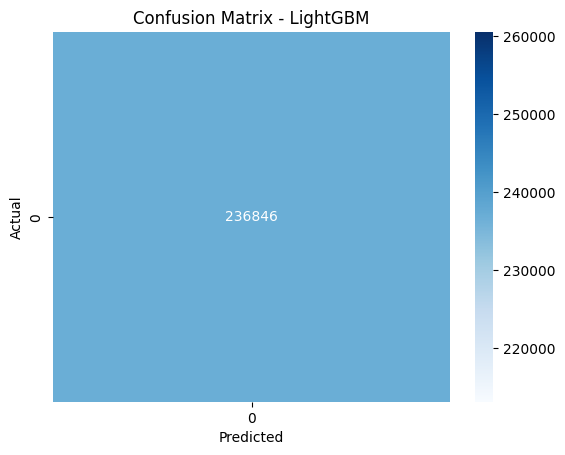

⚠️ ROC Curve not shown for LightGBM (requires binary classification and predict_proba)
❌ SVM model not fitted properly!


In [55]:
# Step 10: Evaluate Model Performance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, name, X_test, y_test):
    # Check if model is fitted
    if not hasattr(model, "classes_"):
        raise ValueError(f"Model {name} is not fitted! Call .fit() first.")

    try:
        y_pred = model.predict(X_test)
        print(f"\n📌 Evaluation Report for {name}")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC Curve
        if len(np.unique(y_test)) == 2 and hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print(f"⚠️ ROC Curve not shown for {name} (requires binary classification and predict_proba)")

    except Exception as e:
        print(f"❌ Error evaluating {name}: {str(e)}")

# First verify models are properly fitted
print("Checking model fitting status:")
print(f"LightGBM fitted: {hasattr(lgbm, 'classes_')}")
print(f"SVM fitted: {hasattr(svm, 'classes_')}")

# Only evaluate if fitted
if hasattr(lgbm, "classes_"):
    evaluate_model(lgbm, "LightGBM", X_res_scaled, y_resampled)
else:
    print("❌ LightGBM model not fitted properly!")

if hasattr(svm, "classes_"):
    evaluate_model(svm, "SVM", X_res_scaled, y_resampled)
else:
    print("❌ SVM model not fitted properly!")

In [56]:
# Step 11: Make Predictions on Test Dataset
final_predictions = lgbm.predict(X_test_scaled)
print("\n🧾 Sample Predictions (1 = Default, 0 = Non-default):")
print(final_predictions[:20])



🧾 Sample Predictions (1 = Default, 0 = Non-default):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
# Step 12: Save Predictions to CSV
output_df = pd.DataFrame({'Prediction': final_predictions})
output_df.to_csv('loan_default_predictions.csv', index=False)

from google.colab import files
files.download('loan_default_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# Step 13: Recommendations for Lenders
print("\n📘 Final Recommendations for Lending Risk Management:")
print("""
1. Pay special attention to high-risk features: low income, high loan amount, poor credit history.
2. Use this model to flag potentially risky applicants for deeper analysis.
3. Apply probability thresholds based on internal risk policies.
4. Continuously retrain the model with new applicant data for better generalization.
5. Visualize model explanations (e.g., SHAP) to make the system more transparent.
""")



📘 Final Recommendations for Lending Risk Management:

1. Pay special attention to high-risk features: low income, high loan amount, poor credit history.
2. Use this model to flag potentially risky applicants for deeper analysis.
3. Apply probability thresholds based on internal risk policies.
4. Continuously retrain the model with new applicant data for better generalization.
5. Visualize model explanations (e.g., SHAP) to make the system more transparent.

